# Module 7 Activity: Classification

In this module, we will be focusing on a simple classification problem. We will be looking at [Kickstarter Data](https://www.kaggle.com/kemical/kickstarter-projects) and attempting to classify projects as successful or failed based on the different attributes of each project, such as the monetary goal, the number of backers, and how long the project was on Kickstarter.

This is a problem of binary classification, where there are two possible outcomes - success or failure.

In [6]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's explore our data a little bit. We'll load it in the cell below.

In [7]:
ks = pd.read_csv('ks_2020.csv')
print(ks.shape)
ks.head()

(261358, 12)


,name,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,duration,name_length
0,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,30000.0,2017-09-02,failed,15,US,30000.0,60,45
1,Where is Hank?,Film & Video,USD,2013-02-26,45000.0,2013-01-12,failed,3,US,45000.0,45,14
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,5000.0,2012-03-17,failed,1,US,5000.0,30,49
3,Monarch Espresso Bar,Food,USD,2016-04-01,50000.0,2016-02-26,successful,224,US,50000.0,35,20
4,Support Solar Roasted Coffee & Green Energy! ...,Food,USD,2014-12-21,1000.0,2014-12-01,successful,16,US,1000.0,20,60


For a classification model, we want to be able to test our model on data that it hasn't seen before. If we try to test it on a point that it already knows the answer for, it'll be correct 100% of the time! For this reason, we split up our data into a training set and a test set. The cell below accomplishes this - it sets aside 10% of the data for testing.

In [15]:
def train_test_split(data, test_size, seed=42):
    np.random.seed(seed)
    data_size = len(data)
    test_data_len = int(test_size * data_size)
    train_data_len = data_size - test_data_len
    test_indices = np.random.choice(np.arange(data_size), test_data_len, replace=False)
    test = data.loc[test_indices]
    train = data[~data.index.isin(test_indices)]
    return train, test
    
train, test = train_test_split(ks, test_size = 0.1)

In [16]:
train.head()

,name,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,duration,name_length
0,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,30000.0,2017-09-02,failed,15,US,30000.0,60,45
1,Where is Hank?,Film & Video,USD,2013-02-26,45000.0,2013-01-12,failed,3,US,45000.0,45,14
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,5000.0,2012-03-17,failed,1,US,5000.0,30,49
3,Monarch Espresso Bar,Food,USD,2016-04-01,50000.0,2016-02-26,successful,224,US,50000.0,35,20
4,Support Solar Roasted Coffee & Green Energy! ...,Food,USD,2014-12-21,1000.0,2014-12-01,successful,16,US,1000.0,20,60


In [17]:
train.shape, test.shape

((235223, 12), (26135, 12))

In this module, we'll be implementing a k-nearest neighbors classifier. The idea behind this type of classifier is to look at the k points closest to our point of interest, and classify our point as whatever category the majority of surrounding points are. For example, look at the image of the plot below. The green point has a single nearest neighbor, which is a Sycamore. Of its 5 closest neighbors, 3 are Birch. This would lead us to classify our green point as Birch if we were using KNN with k = 5. 

In our case, rather than classifying trees based on tree diameter and height, we're looking to see if we can classify kickstarter projects as successful or failed.

<p><a href="https://otd.gitbook.io/book/module-7/nearest-neighbors"><img src="knn.PNG"></a></p>

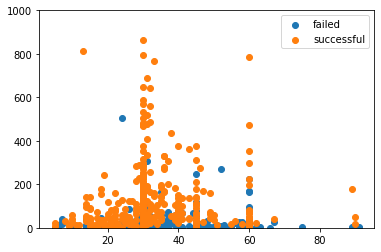

In [19]:
# eda
samp = ks.sample(1000)
for state in samp['state'].unique():
    samp_state = samp[samp['state'] == state]
    plt.scatter(samp_state['duration'], samp_state['backers'], label=state)
plt.ylim(0, 1000)
plt.legend()
plt.show()

K-nearest neighbors (KNN) classification works on distances between points, so we'll create a function that tells us the distance between a set of points.

In [20]:
def distance(features_array_1, features_array_2):
    return np.mean(np.sqrt(np.sum((features_array_1 - features_array_2)**2)))

In [21]:
train.head()

,name,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,duration,name_length
0,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,30000.0,2017-09-02,failed,15,US,30000.0,60,45
1,Where is Hank?,Film & Video,USD,2013-02-26,45000.0,2013-01-12,failed,3,US,45000.0,45,14
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,5000.0,2012-03-17,failed,1,US,5000.0,30,49
3,Monarch Espresso Bar,Food,USD,2016-04-01,50000.0,2016-02-26,successful,224,US,50000.0,35,20
4,Support Solar Roasted Coffee & Green Energy! ...,Food,USD,2014-12-21,1000.0,2014-12-01,successful,16,US,1000.0,20,60


For KNN, we need to select numerical features in order to be able to calculate distances. Our data contain various numerical features, and we'll use all of them - these are `goal`, `backers`, `duration`, and `name_length`. We need to select the columns that contain these features.

In [37]:
train_features = train[['goal', 'backers', 'duration', 'name_length']]
train_labels = train['state']
test_features = test[['goal', 'backers', 'duration', 'name_length']]
test_labels = test['state']

For the first Kickstarter project in our dataset, the 'KILLER GRANNY: based on our award-winning script', we'll compute the distance to the rest of the projects in the dataset.

In [38]:
train_features

,goal,backers,duration,name_length
0,30000.0,15,60,45
1,45000.0,3,45,14
2,5000.0,1,30,49
3,50000.0,224,35,20
4,1000.0,16,20,60
...,...,...,...,...
261352,1700.0,1,30,7
261353,6500.0,4,30,37
261354,1500.0,5,27,9
261356,15000.0,6,31,24


In [39]:
# distance between first and second projects
train_features.iloc[0]

goal           30000.0
backers           15.0
duration          60.0
name_length       45.0
Name: 0, dtype: float64

In [40]:
train_features.iloc[1]

goal           45000.0
backers            3.0
duration          45.0
name_length       14.0
Name: 1, dtype: float64

In [41]:
distance(train_features.iloc[0], train_features.iloc[1])

15000.044333267819

### Standard Units

We want to standardize these units, though! The distance between goals might be a lot larger than the distance between name lengths, so we can turn our data into "standard units" -- that is, we will subtract our data from the mean and divide by the standard deviation to get our data into units that make more sense for our analysis.

In [ ]:
def standard_units(array):
    m = np.mean(array)
    sd = np.std(array)
    return (array - m)/sd

We can now apply our standard units function to all of our data.

In [33]:
train_features = train_features.apply(standard_units)
test_features = test_features.apply(standard_units)

Let's check the distance between the first two train features!

In [34]:
distance(train_features.iloc[0], train_features.iloc[1])

2.2658141715697986

And between the first test feature and the first train feature:

In [35]:
 distance(test_features.iloc[0], train_features.iloc[0])

3.1119839694473215

### Question 1: Writing the Function
Now, let's write a function to calculate the top "k" neighbors for each piece of test data:

In [49]:
def k_nn(train_features, train_labels, test_data, k):
    feature_labels = []
    feature_distances = []
    for i in range(train_features.shape[0]):
        train_i = train_features.iloc[i]
        train_label = train_labels.iloc[i]
        feature_labels.append(train_label)
        feature_distances.append(distance(test_data, train_i))
    
    
    k_indices = (np.array(feature_distances)).argsort()[:k]
    k_labels = np.take(feature_labels, k_indices)
    # k_labels is going to be an array of k values, all either "failed" or "successful"!
    num_failed = np.count_nonzero(k_labels == 'failed')
    num_successful = np.count_nonzero(k_labels == 'successful')
    if num_failed >= num_successful:
        return 'failed'
    else:
        return 'successful'

Let's try classifying the first piece of test data using 3-nn; we'll use only the first 1000 pieces of data for speed (try running it on all the data later! how long does it take?):

In [50]:
k_nn(train_features.iloc[0:1000], train_labels.iloc[0:1000], test_features.iloc[0], 3)

'failed'

### Question 2:
Try running the 3-nearest neighbors classifier on 100 pieces of training data; how many did it get right? How many did it get wrong?

In [51]:
num_correct = 0
for i in range(100):
    test_data = test_features.iloc[i]
    label = k_nn(train_features.iloc[0:1000], train_labels.iloc[0:1000], test_data, 3)
    if label == test_labels.iloc[i]:
        num_correct += 1

pct_correct = num_correct / 100

In [52]:
pct_correct

0.82

### Question 3:
What happens if you change the value of k?

In [ ]:
for k in [1, 2, 4, 5]:
    num_correct = 0
    for i in range(100):
        test_data = test_features.iloc[i]
        label = k_nn(train_features.iloc[0:1000], train_labels.iloc[0:1000], test_data, 3)
        if label == test_labels.iloc[i]:
            num_correct += 1

    pct_correct = num_correct / 100
    print("k =", k, "; pct correct =", pct_correct)